## OPT Trout processing, fluorescence
* MAG 0.5, C mount.
* embedded in 1.5%, 2ECI
* FL with blue torch excitation, 590nm LP detections
* 400 steps and undersampling

In [1]:
import sys
import os
from pathlib import Path
import gc
import psutil
from time import perf_counter

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets

from tqdm import tqdm
from scipy.ndimage import variance
from IPython.display import display

import tomopy as tom
from tomopy.recon.rotation import find_center_vo, find_center

import utils_opt as u
from napari_opt_handler.corrections import Correct
from data_loader import OptLoader

%load_ext autoreload
%autoreload 2

## FL LP590

In [3]:
root_folder = Path('/opt/shared/opt_paper_david/raw_data/')

In [4]:
folder = root_folder.joinpath('2024_08_01-fluorescence/2024_08_01-11-22-21_fl_400')
folder_corr = root_folder.joinpath('2024_08_01-fluorescence')

# no WL correction for FL
ddark = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-05-42_dark_field.tiff')), cv2.IMREAD_UNCHANGED)
dhot = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-03-54_corr_hot.tiff')), cv2.IMREAD_UNCHANGED)

In [5]:
try:
    u.rename(folder)
except Exception as e:
    print(e)

In [6]:
stride = 1
# Load folder
opt = OptLoader(folder, depth=np.int16, format='tiff')
opt.load_folder(mode='simple', stride=stride)
n_steps, height, width = opt.data.shape
opt.data.shape

100%|██████████| 400/400 [00:04<00:00, 97.49it/s] 


(400, 2048, 1536)

In [7]:
# widget to select roi
ix0 = widgets.BoundedIntText(value=0, min=0, max=width, step=1, description='x0:', disabled=False)
ix1 = widgets.BoundedIntText(value=1536, min=0, max=width, step=1, description='x1:', disabled=False)
iy0 = widgets.BoundedIntText(value=0, min=0, max=height, step=1, description='y0:', disabled=False)
iy1 = widgets.BoundedIntText(value=2048, min=0, max=height, step=1, description='y1:', disabled=False)

In [8]:
# to reproduce the paper, keep default values
display(ix0), display(ix1)
display(iy0), display(iy1)

BoundedIntText(value=0, description='x0:', max=1536)

BoundedIntText(value=1536, description='x1:', max=1536)

BoundedIntText(value=0, description='y0:', max=2048)

BoundedIntText(value=2048, description='y1:', max=2048)

(None, None)

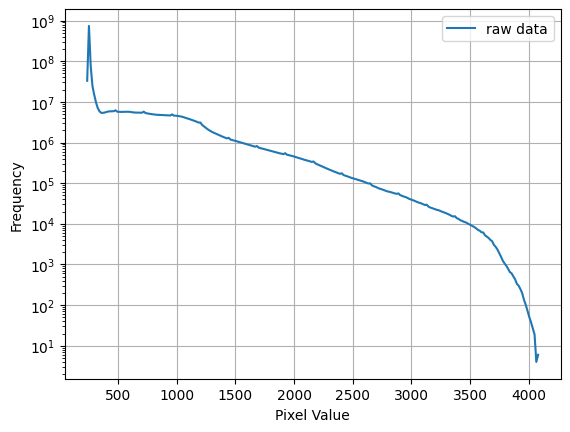

In [9]:
hists = u.histogram(opt.data, 'raw data')
u.plot_histograms(hists)

In [10]:
cmap=plt.cm.Greys_r

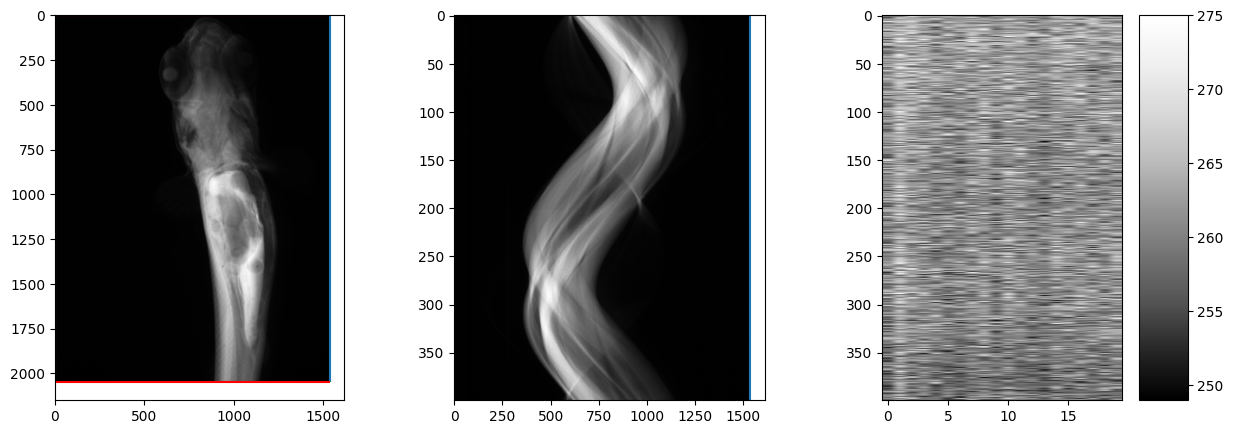

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# --- subplot 1 ---
axs[0].imshow(opt.data[min(100, n_steps-1)], cmap=cmap)
axs[0].set_aspect(1)
axs[0].vlines([ix0.value, ix1.value], 0, height-1)
axs[0].hlines([iy0.value, iy1.value], 0, width-1, colors='r')

# --- subplot 2 ---
axs[1].imshow(opt.data[:, height//2, :], cmap=cmap)
axs[1].set_aspect(5)
axs[1].vlines([ix0.value, ix1.value], 0, n_steps-1)

# --- subplot 3 ---
im = axs[2].imshow(opt.data[:, height//2, :20], cmap=cmap)
axs[2].set_aspect(0.08)
fig.colorbar(im, ax=axs[2], aspect=8)

plt.show()

In [12]:
data = opt.data[:,
                iy0.value:iy1.value,
                ix0.value:ix1.value,
               ]
n_steps, height, width = data.shape

try:
    ddark = ddark[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use DARK')
    
try:
    dhot = dhot[iy0.value:iy1.value,
                ix0.value:ix1.value,]
except NameError:
    print('You probably do not use HOT')
    
try:
    dflat = dflat[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use FLAT')

You probably do not use FLAT


### Corrections

In [13]:
try:
    del Corr
except:
    pass
Corr = Correct(std_mult=7)
Corr.set_dark(dark=ddark)
Corr.set_bad(bad=dhot)

In [14]:
gc.collect()
data_corr = Corr.correct_dark_bright(
                data, modality='Emission', useDark=True, useBright=False)

print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

After Correction max: 3828, min: 0.


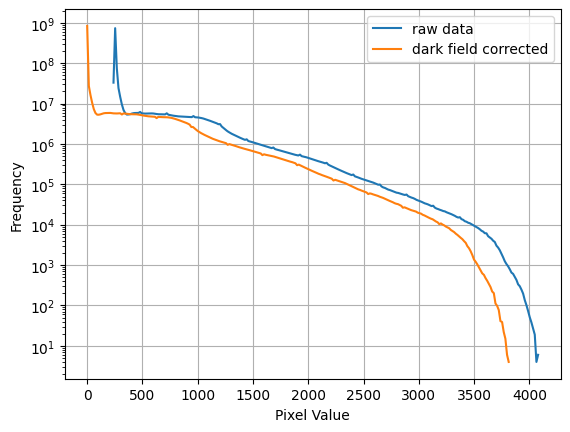

In [15]:
hists = u.histogram(data_corr, hist_dict=hists, name='dark field corrected')
u.plot_histograms(hists)

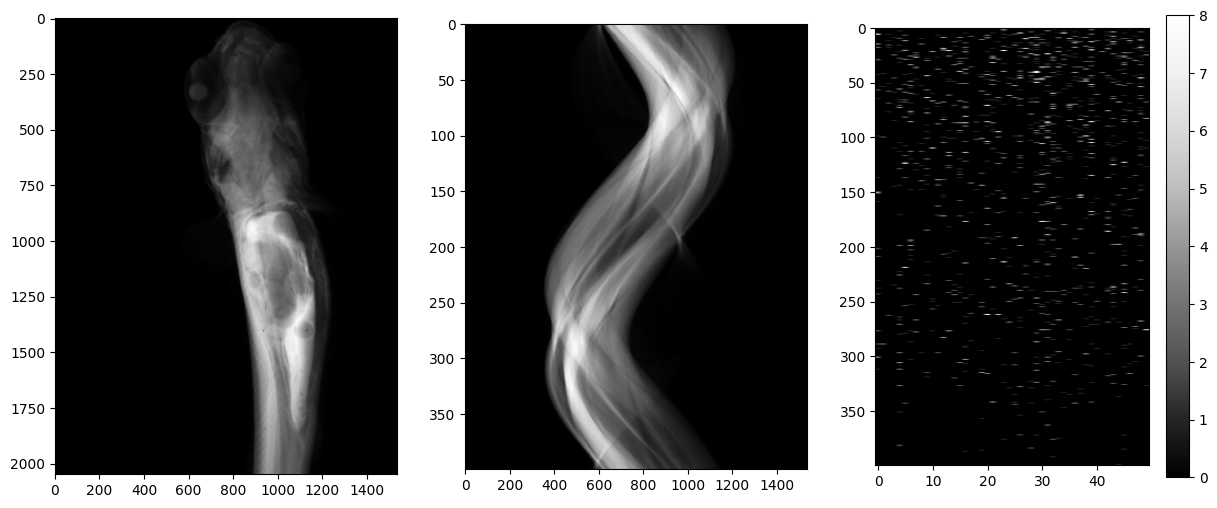

In [16]:
plt.figure(figsize=(15, 6))
plt.subplot(131), plt.imshow(data_corr[min(100, n_steps-1)], cmap=cmap)
plt.subplot(132), plt.imshow(data_corr[:, height//2, :], cmap=cmap), plt.gca().set_aspect(5)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50], cmap=cmap), plt.gca().set_aspect(0.2), plt.colorbar()
plt.show()

#### Hot pixel correction

In [17]:
Corr.get_bad_pxs()
print(len(Corr.hot_pxs), len(Corr.dead_pxs))

2923 0


In [18]:
data_corr = u.badcorr3D(data_corr, Corr)

400it [00:13, 30.29it/s]


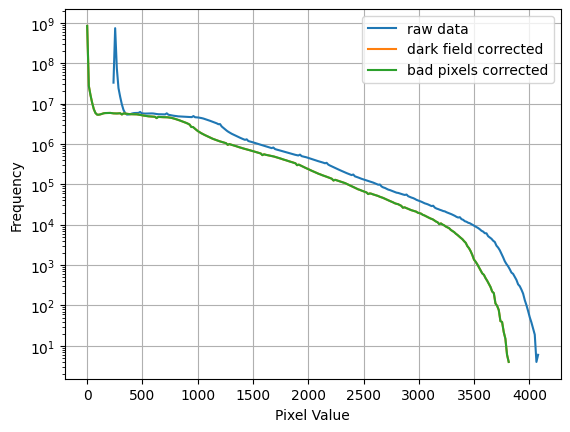

In [19]:
hists = u.histogram(data_corr, hist_dict=hists, name='bad pixels corrected')
u.plot_histograms(hists)

In [20]:
print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

After Correction max: 3828.0, min: 0.0.


#### Intensity correction

In [21]:
intCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='Int corr?',
                disabled=False
            )

display(intCorr)

Select(description='Int corr?', options=('Yes', 'No'), rows=2, value='Yes')

Using avg of the corners in the img stack as ref
shape ref: [(50, 50), (50, 50), (50, 50), (50, 50)]


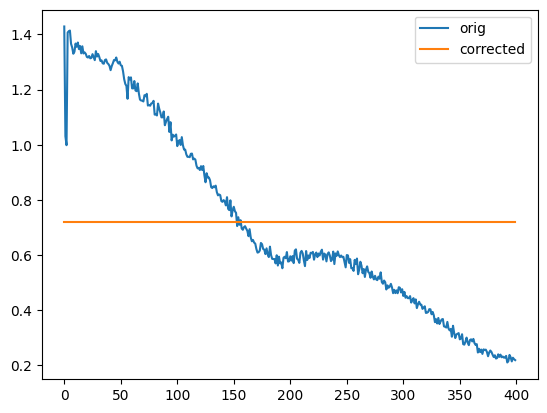

0.7188555


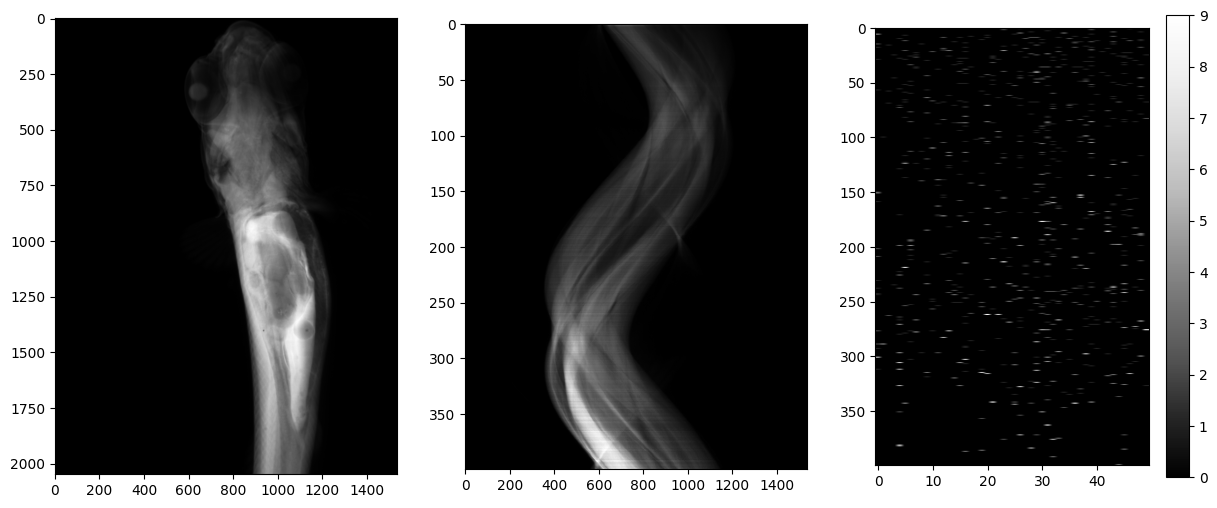

In [22]:
# intensity correction (Without referencing no good for the PL)
if intCorr.value == 'Yes':
    data_corr, report_dict = Corr.correct_int(data_corr, mode='integral',
                                              use_bright=False,
                                              rect_dim=50)
    
    plt.plot(report_dict['stack_orig_int'], label='orig'), 
    plt.plot(report_dict['stack_corr_int'], label='corrected')
    plt.legend()
    plt.show()
    
    print(report_dict['ref'])

    plt.figure(figsize=(15, 6))
    plt.subplot(131), plt.imshow(data_corr[min(100, n_steps-1)], cmap=cmap)
    plt.subplot(132), plt.imshow(data_corr[:, height//2, :], cmap=cmap), plt.gca().set_aspect(5)
    plt.subplot(133), plt.imshow(data_corr[:, height//2, :50], cmap=cmap), plt.gca().set_aspect(0.2), plt.colorbar()
    plt.show()

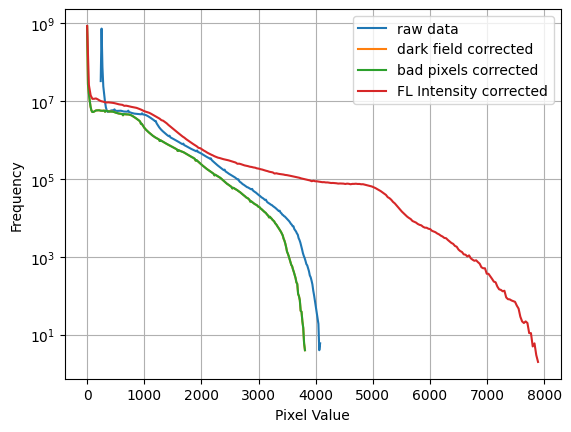

In [ ]:
hists = u.histogram(data_corr, hist_dict=hists, name='Excitation Intensity corrected')
u.plot_histograms(hists)

#### Correcting for FL bleaching

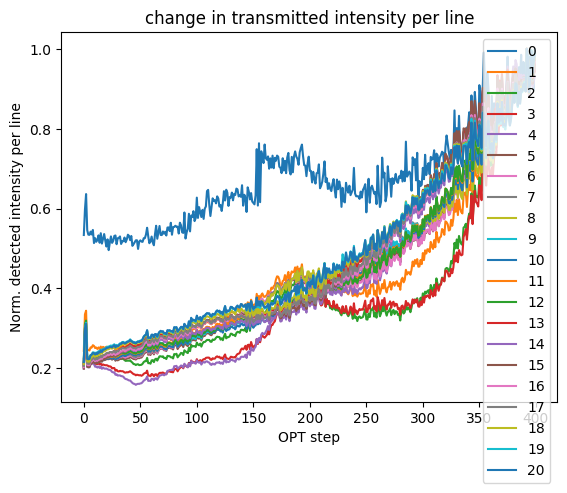

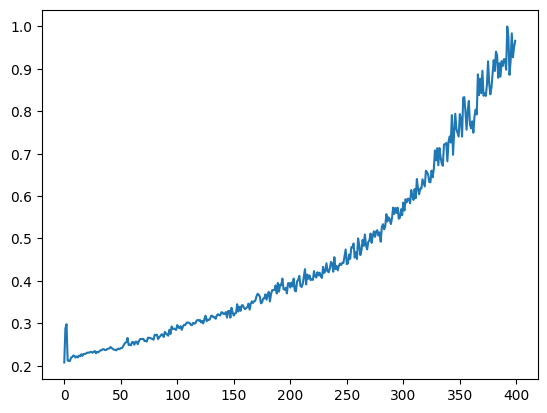

In [24]:
# avoid plotting 1000s of curves
# run this only if you stride in rows a lot
meanOverColumns = data_corr.mean(axis=2).T
for i, sino in enumerate(meanOverColumns[::100]):
    plt.plot(sino/max(sino), label=i)


plt.legend()
plt.xlabel('OPT step')
plt.ylabel('Norm. detected intensity per line')
plt.title('change in transmitted intensity per line')
plt.show()

# the same but averaged over all the lines
plt.plot(meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0)))

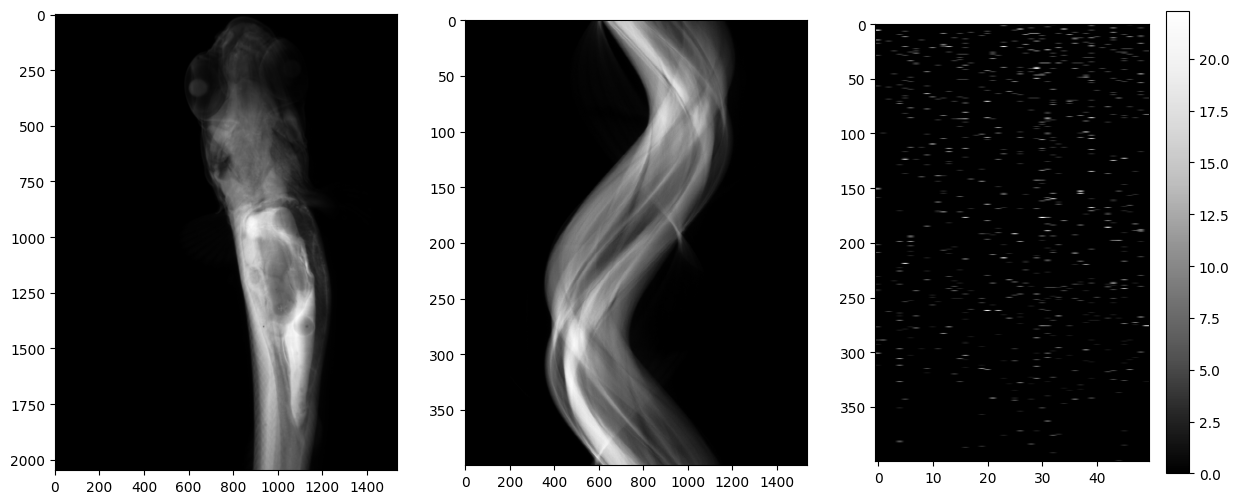

In [25]:
decay = meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0))
data_corr = np.divide(data_corr.T, decay).T

plt.figure(figsize=(15, 6))
plt.subplot(131), plt.imshow(data_corr[min(100, n_steps-1)], cmap=cmap)
plt.subplot(132), plt.imshow(data_corr[:, data_corr.shape[1]//2, :], cmap=cmap), plt.gca().set_aspect(5)
plt.subplot(133), plt.imshow(data_corr[:, data_corr.shape[1]//2, :50], cmap=cmap), plt.gca().set_aspect(0.2), plt.colorbar()
plt.show()

In [26]:
del decay
del meanOverColumns
gc.collect()

14441

### Figure paper related to corrections.

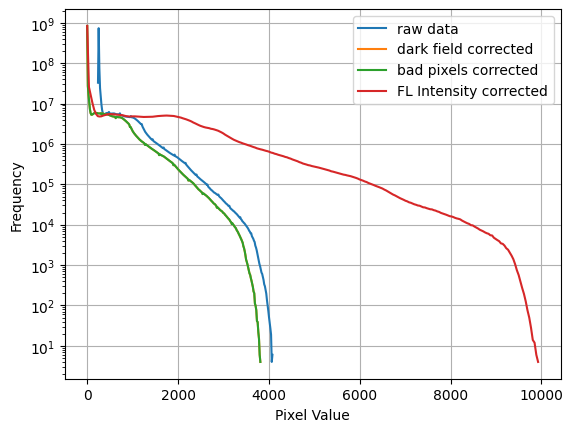

In [ ]:
hists = u.histogram(data_corr, hist_dict=hists, name='FL Bleach corrected')
u.plot_histograms(hists)

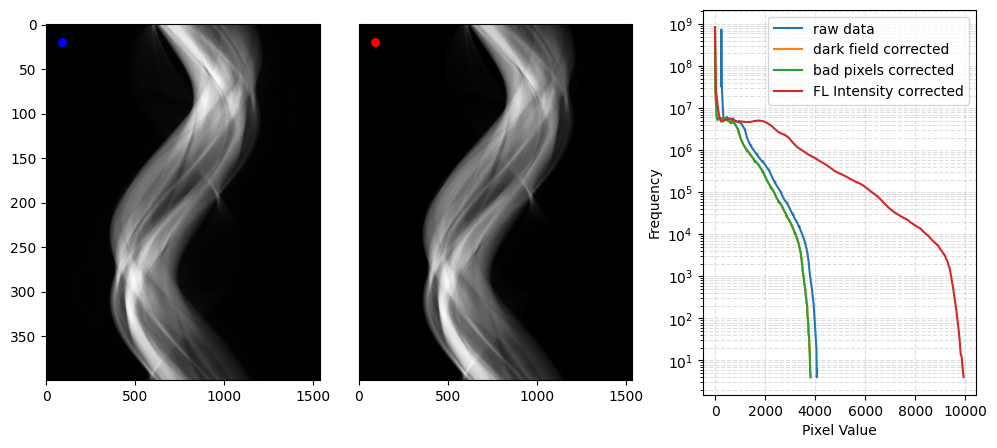

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# --- subplot 1 ---
# axs[0].imshow(opt.data[min(100, n_steps-1)])
axs[0].imshow(opt.data[:, height//2, :], cmap=plt.cm.Greys_r)
axs[0].scatter(90, 20, color="blue", s=30)
axs[0].set_aspect(5)

# --- subplot 2 ---
# axs[1].imshow(data_corr[min(100, n_steps-1)])
axs[1].imshow(data_corr[:, height//2, :], cmap=plt.cm.Greys_r)
axs[1].scatter(90, 20, color="red", s=30)
axs[1].set_aspect(5)
axs[1].set_yticks([])

u.move_horizontal(axs[1], -0.013)

# --- subplot 3 ---
u.plot_histograms_paper(axs[2], hists)

plt.savefig('fig_output/fig1a_fl_corrections.png', dpi=180)
plt.show()

#### Clean the memory

In [28]:
try:
    del data
except:
    print('no data')

try:
    del opt
except:
    print('no opt')

try:
    del full_recon
except:
    print('no full_recon')

n_steps = data_corr.shape[0]
height, width = data_corr.shape[1], data_corr.shape[2]

no full_recon


### Clip based on the histogram
- This is optional, we did not do it for the paper

In [29]:
print(f"number of pixels > 4095: {np.sum(data_corr > 4095)}")
print(f'Maximum pixel value: {np.amax(data_corr)}')

# count zeros in data_corr
print(f'Number of pixels with value 0: {np.sum(data_corr == 0)}')

assert np.sum(data_corr < 0) == 0, "Negative pixel values found!"

number of pixels > 4095: 18012934
Maximum pixel value: 9967.294522779699
Number of pixels with value 0: 710100315


In [36]:
# optional clipping
# data_corr = np.clip(data_corr, a_min=0, a_max=4095)

#### Reconstruction setup

In [29]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}
n_steps, height, _ = data_corr.shape
thetas = u.calc_thetas(n_steps, half=False)
np.amax(data_corr), np.amin(data_corr)

(np.float64(9967.294522779699), np.float64(0.0))

### Finding COR
- this section can be skipped, the correct value of 779 is hardcoded into the next section

In [ ]:
beg = perf_counter()
var_fbp_cuda = []
cors = np.arange(770, 787, 1)
for cor in cors:
    recon_fbp_cuda = tom.recon(data_corr[:, 50::100, :],
                        thetas,
                        center=cor,
                        algorithm=tom.astra,
                        options=options,
                        ncore=1)
    recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.90)


    var_fbp_cuda.append(np.sum([variance(k) for k in recon_fbp_cuda]))
    print(cor, end='\r')

end = perf_counter()
print()
print(f"Execution time: {np.round(end-beg, 2)} s")
print('######################')
print(f"index of the maximum variance: {np.argmax(var_fbp_cuda)}, COR value: {cors[np.argmax(var_fbp_cuda)]}")

786
Execution time: 4.1 s
######################
index of the maximum variance: 9, COR value: 779


#### Plot variance of stack

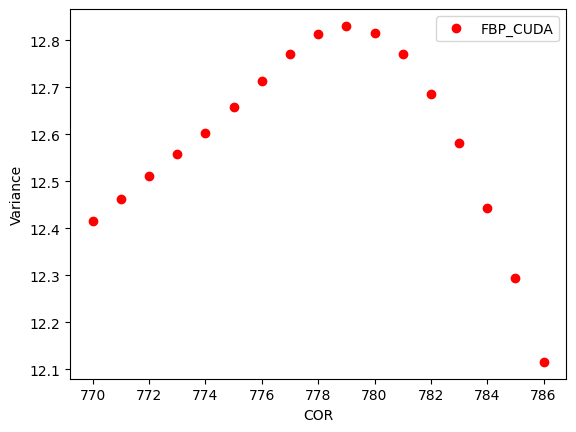

In [61]:
plt.plot(cors, var_fbp_cuda, 'ro', label=options['method'])
plt.xlabel('COR')
plt.ylabel('Variance')
plt.legend()
plt.show()

### Reconstruction

In [ ]:
import subprocess
import sys

subprocess.run([
    sys.executable,
    "reconstruct_astra.py"
], check=True)

In [30]:
beg=perf_counter()
recon_fbp_cuda = tom.recon(data_corr,
                    thetas,
                    center=779,
                    algorithm=tom.astra,
                    options=options,
                    ncore=1)
recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.950)
end = perf_counter()
print(f"Execution time: {np.round(end-beg, 2)} s")

# clip negative values
recon_fbp_cuda = np.maximum(recon_fbp_cuda, 0)

# del data_corr
gc.collect()

Execution time: 19.43 s


22189

In [32]:
print(f'reconstruction shape: {recon_fbp_cuda.shape}')
print(f'min-max range of the reconstructed volume: {np.amin(recon_fbp_cuda)} - {np.amax(recon_fbp_cuda)}')
print(f'size of the volume: {sys.getsizeof(recon_fbp_cuda) / 1e9} GB')

reconstruction shape: (2048, 1536, 1536)
min-max range of the reconstructed volume: 0.0 - 40.07316970825195
size of the volume: 19.327352976 GB


min max of reconstructions: 0.0 40.07317


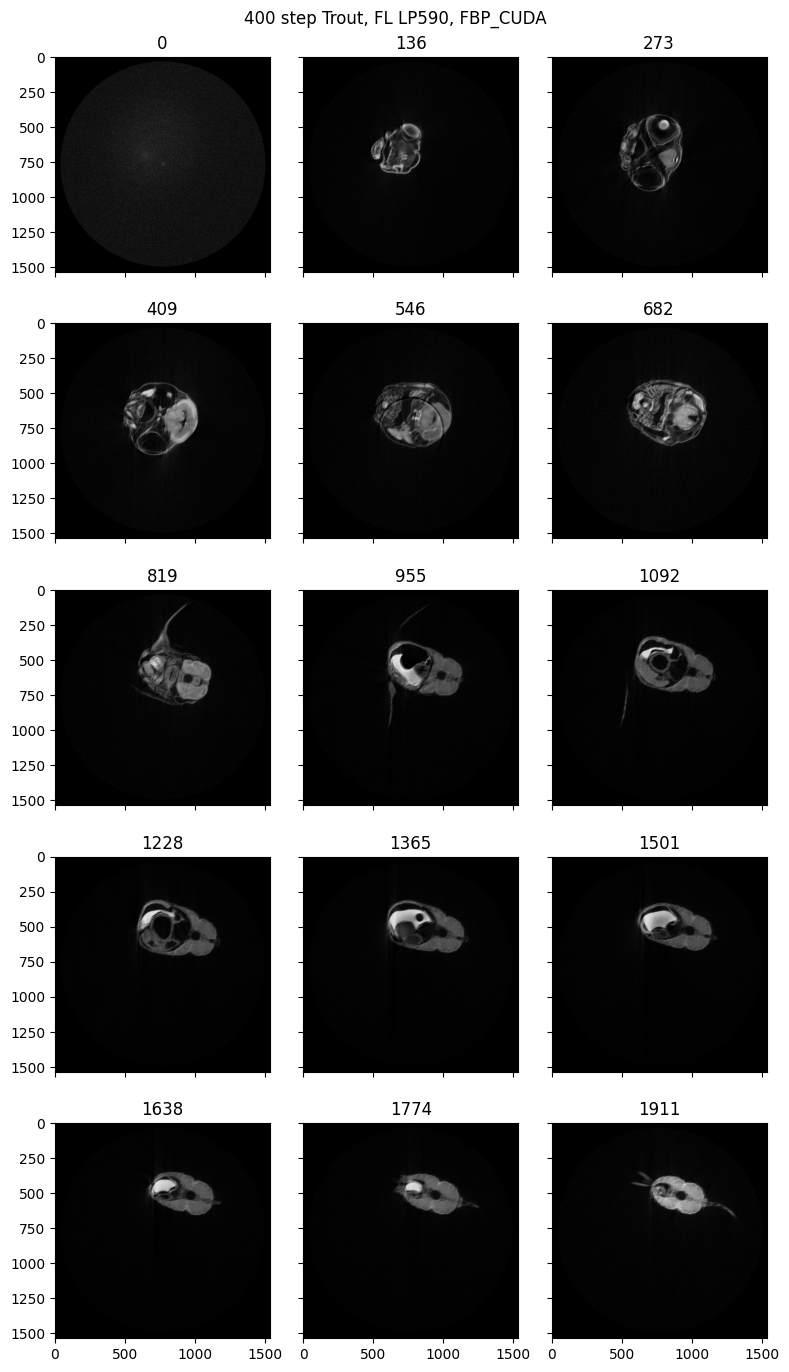

In [33]:
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
lineidx = []
print('min max of reconstructions:',
      np.amin(recon_fbp_cuda),
      np.amax(recon_fbp_cuda))

for i in range(len(recon_fbp_cuda)):
    
    try:
        line = int(height/15*i)
        ax[i//3, i%3].imshow(recon_fbp_cuda[line], cmap=plt.cm.Greys_r)
        ax[i//3, i%3].set_title(line)
        lineidx.append(line)
    except:
        pass
plt.suptitle('400 step Trout, FL LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('fig_output/0801_trout_fbp-cuda_400_fl_lp590.png', dpi=180)
plt.show()

### Normalized plot

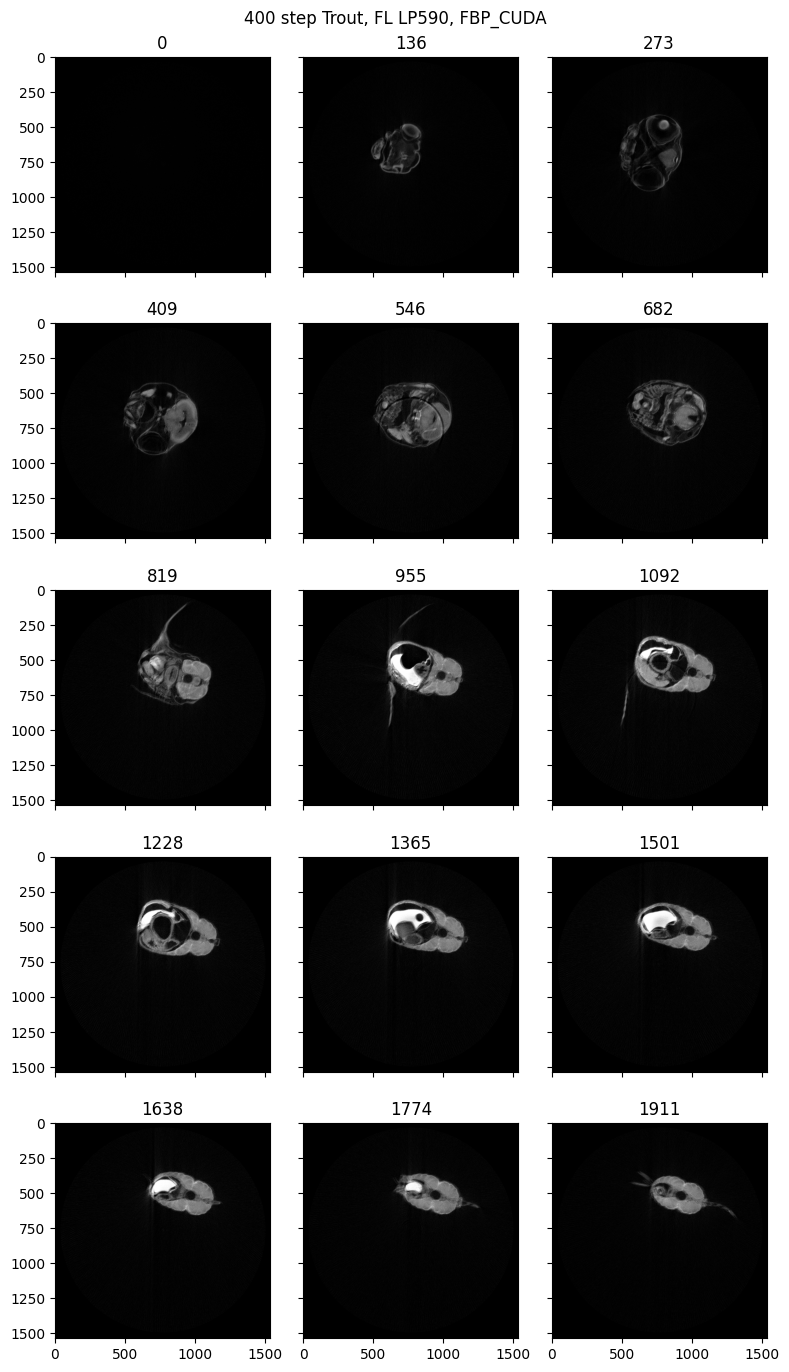

In [34]:
# Saturation factor
saturation_factor = 2
# same but normalize
cmax = np.amax(recon_fbp_cuda)
cmin = np.amin(recon_fbp_cuda)
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)

for i in range(len(recon_fbp_cuda)):
    try:
        line = int(height/15*i)
        ax[i//3, i%3].imshow(recon_fbp_cuda[line],
                             cmap=plt.cm.Greys_r,
                             vmin=cmin, vmax=cmax / saturation_factor)
        ax[i//3, i%3].set_title(line)
    except:
        pass
plt.suptitle('400 step Trout, FL LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('fig_output/0801_trout_fbp-cuda_400_fl_lp590_same_cscale.png', dpi=180)
plt.show()

### Paper figure

In [35]:
lineidx = [200, 1000, 1500]
recon_fbp_cuda.shape

(2048, 1536, 1536)

In [36]:
# max projection alone
maxproj= np.max(recon_fbp_cuda, axis=2)

# normalization step
data = [recon_fbp_cuda[k] for k in lineidx]
# data = [u.norm2d(k) for k in data]
# data = [np.clip(k, a_min=0, a_max=4095) for k in data]

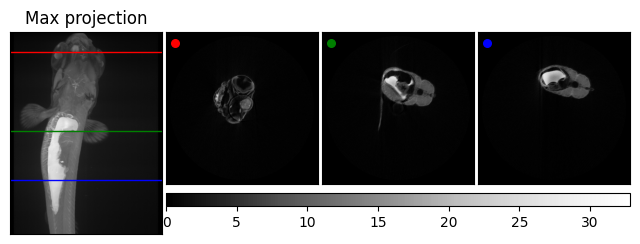

13497

In [37]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(
    2, 4,
    height_ratios=[1.0, 0.032],
    width_ratios=[1.3, 1.3, 1.3, 1.3],
    hspace=-0.5
)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[1, 1:])


ax0.imshow(maxproj, cmap=plt.cm.Greys_r)
ax0.axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax0.axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax0.axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax0.set_title('Max projection')
ax0.set_yticks([]), ax0.set_xticks([])


ax1.imshow(data[0], cmap=plt.cm.Greys_r)
ax1.scatter(90, 110, color="red", s=30)
ax1.set_yticks([]), ax1.set_xticks([])

ax2.imshow(data[1], cmap=plt.cm.Greys_r)
ax2.scatter(90, 110, color="green", s=30)
ax2.set_yticks([]), ax2.set_xticks([])

im = ax3.imshow(data[2], cmap=plt.cm.Greys_r)
ax3.scatter(90, 110, color="blue", s=30)
ax3.set_yticks([]), ax3.set_xticks([])
cbar = fig.colorbar(
    im,
    cax=cax,
    orientation="horizontal",
)
fig.subplots_adjust(
    hspace=0.02,
    wspace=0.03
)
u.move_up(ax1, 0.063)
u.move_up(ax2, 0.063)
u.move_up(ax3, 0.063)
u.move_up(cax, 0.09)

plt.savefig('fig_output/fig3a_fl.png', dpi=180)
plt.show()
gc.collect()

### Save recons and figure data
- this is optional, because the volumes are large, 8GB when casted to 16bit floats

In [33]:
# del hists
gc.collect()

495

In [34]:
# save data
recon_fbp_cuda = u.data2saveFormat(recon_fbp_cuda)
print(sys.getsizeof(recon_fbp_cuda), recon_fbp_cuda.dtype)

with open('data_output/0801_fl_lp590_400_recon.npy', 'wb') as f:
    np.save(f, recon_fbp_cuda)

: 

In [44]:
# save the 3 slices used in the figure above for later comparison
# slices_paper_fl = np.array([data[k] for k in lineidx], dtype=np.float16)

dict2save = {'max_proj': maxproj,
             'lineidx': lineidx,
             'rescaled_cuts': data}

with open('data_output/paper_recon_slices_fl.npy', 'wb') as f:
    np.save(f, dict2save)

### FL - TR

In [212]:
tr = np.load('../data_output/0801_tr_lp590_400_recon.npy', allow_pickle=True)
fl = np.load('../data_output/0801_fl_lp590_400_recon.npy', allow_pickle=True)

In [213]:
np.amax(tr), np.amin(tr), np.amax(fl), np.amin(fl)  

(4095, 0, 4095, 0)

In [214]:
tr.shape == fl.shape
diff = tr - fl
np.amax(diff), np.amin(diff)

(2030, -3573)

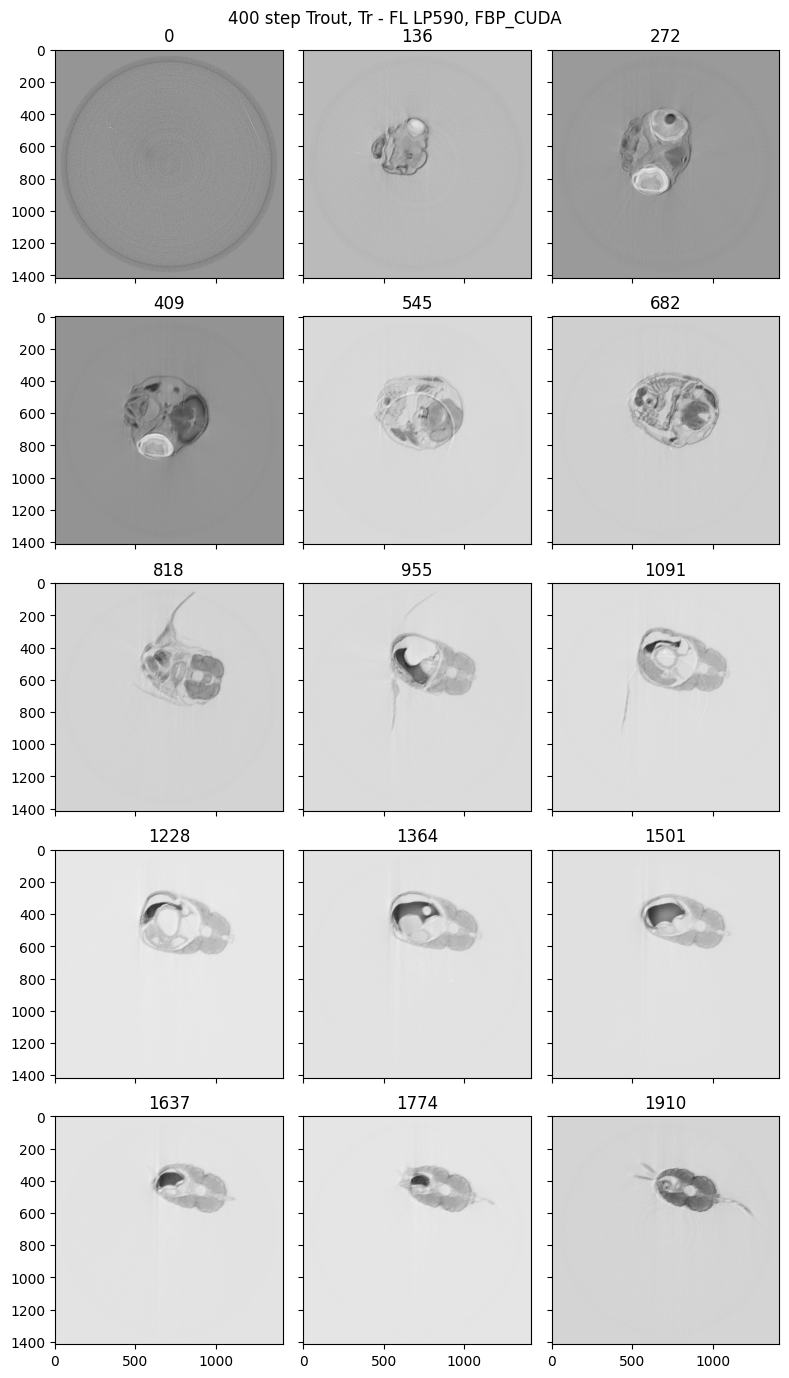

In [296]:
height = tr.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
for i in range(len(tr)):
    try:
        ax[i//3, i%3].imshow(diff[int(height/15*i)], cmap=plt.cm.Greys_r)
        # for the case of stride in rows and plotting everything
        # ax[i//3, i%3].imshow(full_recon[i], cmap=plt.cm.Greys_r)
        ax[i//3, i%3].set_title(int(height/15*i))
    except:
        pass
plt.suptitle('400 step Trout, Tr - FL LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('../fig_output/0801_tr_fl_diff.png', dpi=180)
plt.show()

### Difference figure for paper from loaded data

In [ ]:
lineidx = [688, 955, 1637]
tr.shape

# max projection alone
maxproj= np.max(tr-fl, axis=2)
minproj= np.min(tr-fl, axis=2)
print('max', np.amin(maxproj), np.amax(maxproj))
print('min', np.amin(minproj), np.amax(minproj))
meanproj= np.mean(tr-fl, axis=2)
# normalization step

data = [tr[k]-fl[k] - np.mean((tr[k]-fl[k])[:50, :50]) for k in lineidx]
data = [u.norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]

max -1791 2030
min -3573 -1791


2030 -1791


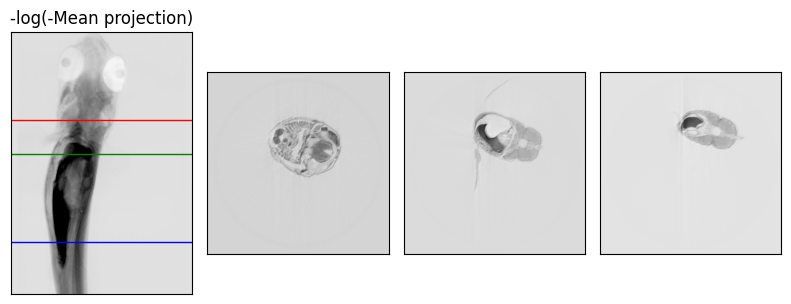

-7.621397 -7.4726887


47286

In [298]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(maxproj),
      np.amin(maxproj))
# ax[0].imshow(meanproj,
#              # vmax=0.5,
#              # vmin=-20,
#              cmap=plt.cm.Greys_r)

ax[0].imshow(tom.minus_log(-meanproj, 2),
             vmin=-7.56,
             # vmax=9,
             cmap=plt.cm.Greys_r)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(-Mean projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr-fl_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
print(
np.amin(tom.minus_log(-meanproj, 2)),
np.amax(tom.minus_log(-meanproj, 2)))
gc.collect()

### Transmission figure for paper from loaded data

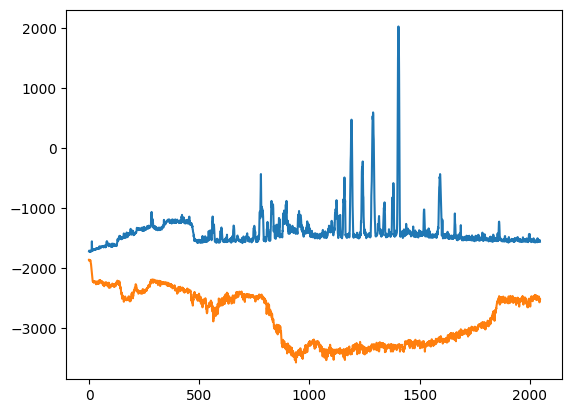

In [238]:
plt.plot(np.amax(tr-fl, axis=(1,2)))
plt.plot(np.amin(tr-fl, axis=(1,2)))

max 496 4095
min 0 496
-6.206576 -8.317522


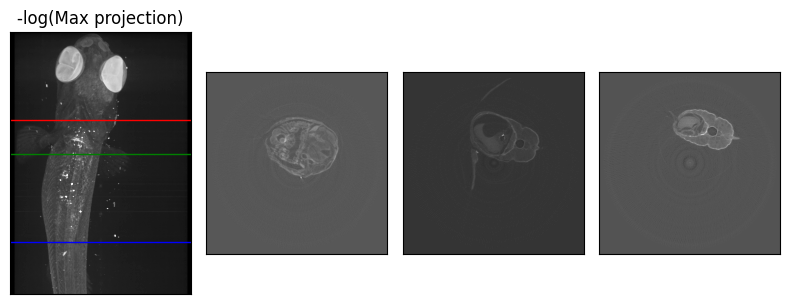

7039

In [ ]:
lineidx = [688, 955, 1637]
tr.shape

# max projection alone
maxproj= np.max(tr, axis=2)
minproj= np.min(tr, axis=2)
print('max', np.amin(maxproj), np.amax(maxproj))
print('min', np.amin(minproj), np.amax(minproj))
meanproj= np.mean(tr, axis=2)
# normalization step

data = [tr[k] - np.mean(tr[k][:50, :50]) for k in lineidx]
data = [u.norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]

fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(tom.minus_log(maxproj, 2)),
      np.amin(tom.minus_log(maxproj, 2)))
ax[0].imshow(tom.minus_log(maxproj, 2),
             # vmin=500,
             vmin=-7,
             cmap=plt.cm.Greys)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
gc.collect()

### FL paper image from loaded data

0 2287
-7.7349963 -8.317522


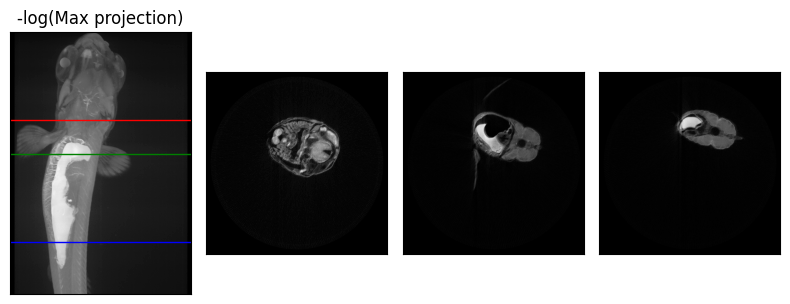

7039

In [ ]:
lineidx = [688, 955, 1637]
fl.shape

# max projection alone
maxproj= np.max(fl, axis=2)
minproj= np.min(fl, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(fl, axis=2)
# normalization step

data = [fl[k] - np.mean(fl[k][:50, :50]) for k in lineidx]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]
data = [u.norm2d(k) for k in data]

fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(tom.minus_log(maxproj, 2)), np.amin(tom.minus_log(maxproj, 2)))
ax[0].imshow(tom.minus_log(maxproj, 2), cmap=plt.cm.Greys)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_fl_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
gc.collect()